In [1]:
import numpy as np
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

from celluloid import Camera
from IPython.display import HTML
import math

# Double well

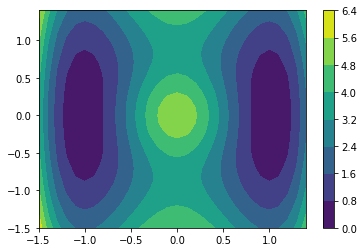

In [2]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)

delta = 0.35
z = (5/2.0)*(x**2-1)**2+y**2 +  np.exp(-(  x**2 +y**2)/delta)/delta
 

#  -2 *x/delta*np.exp(-(  x**2 +y**2)/delta)/delta
#  (-( 2*y)/delta )*np.exp(-(  x**2 +y**2)/delta)/delta

h = plt.contourf(feature_x,feature_y,z)
plt.colorbar()
plt.show()



In [3]:
np.where(z.max() ==z)

(array([0], dtype=int64), array([0], dtype=int64))

In [4]:
z[10,10]

2.340967246976508

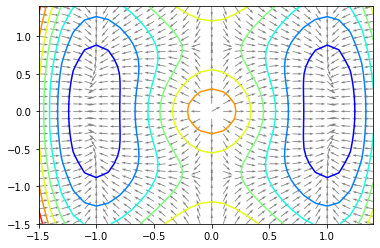

In [5]:
u = -(10*x*(x**2-1)) + 2 * x * np.exp(-(  x**2 +y**2)/delta)/delta**2
v = -(2*y)  +  2* y * np.exp(-(  x**2 +y**2)/delta)/delta**2

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [6]:
delta_tn = torch.tensor(delta)

deriv_x = lambda x,y: -(10*x*(x**2-1)) +  2 * x * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
deriv_y = lambda x,y: -(2*y) +2* y * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
# deriv_y = deriv_x
# prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [9]:
num_samples=30
sigma = 0.5
dt = 0.03
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))

mu_2 = torch.tensor([0.0,0.0])
X_2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_2,torch.eye(2)*0.5).sample((60,1)).reshape((-1,2))

prior_X_0 = X_2

t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=prior_X_0, dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

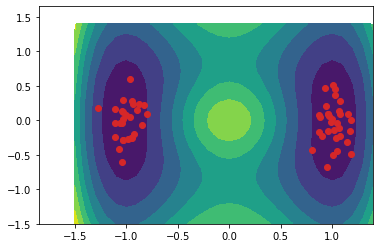

In [10]:
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [21]:
N

34

In [15]:
# sparse enables the nystrom method which is just a low rank approximation of the kernel matrix using
# random subsampling, should not affect interpretability much, ive tested it in all our experiments
# works surprisingly well

sigma= 2 # Works at 1.5 breaks at 0.5, what to do ?
sigma_target = 0.5

mod = 1
iteration = 50

increments = int(iteration / mod)
#  sigma_target =  sigma * decay_sigma**iteration 
decay_sigma = (sigma_target/sigma)**(1.0/increments)

sigma_test = sigma
for i in range(increments):
    sigma_test *= decay_sigma
    print(sigma_test)


1.945309894824571
1.8921152934511918
1.8403753012497501
1.790050141855945
1.7411011265922482
1.6934906247250543
1.6471820345351462
1.6021397551792442
1.5583291593209998
1.5157165665103982
1.4742692172911014
1.4339552480158275
1.3947436663504056
1.356604327447672
1.3195079107728944
1.2834258975629043
1.248330548901612
1.214194884395047
1.1809926614295305
1.148698354997035
1.11728713807222
1.0867348625260582
1.0570180405613805
1.0281138266560665
1.0
0.9726549474122855
0.9460576467255959
0.9201876506248751
0.8950250709279725
0.8705505632961241
0.8467453123625271
0.8235910172675731
0.8010698775896221
0.7791645796604999
0.7578582832551991
0.7371346086455507
0.7169776240079138
0.6973718331752028
0.678302163723836
0.6597539553864472
0.6417129487814521
0.624165274450806
0.6070974421975235
0.5904963307147653
0.5743491774985175
0.55864356903611
0.5433674312630291
0.5285090202806902
0.5140569133280333
0.5


In [16]:



result = MLE_IPFP(
    X_0,X_1,N=N,sigma=sigma,
    prior_drift=prior_drift, sparse=False, 
    prior_X_0=prior_X_0, iteration=iteration, refinement_iterations=0,
    decay_sigma=decay_sigma
)

Log dir not found


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.92it/s]


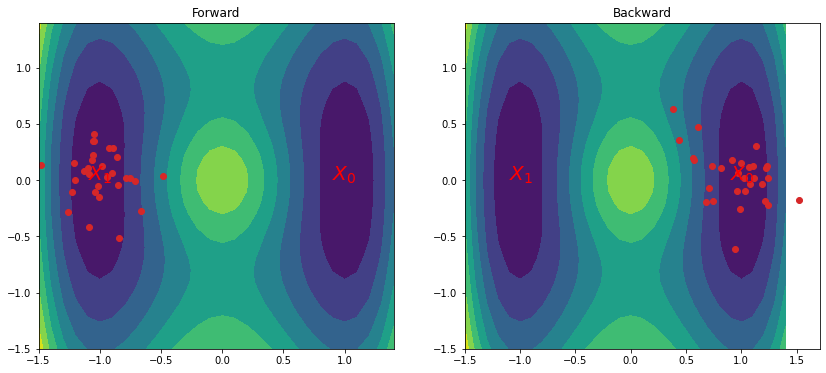

In [18]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')